In [18]:
import random
from math import factorial, comb
import numpy as np
import matplotlib.pyplot as plt

# Notebook Outline

We begin with an exploration of a typical deck of playing cards. We introduce functions `Lehmer` and `factoradic` which allow for the classification of permutations, and the `Permuter` class holds a number of different functions for shuffling in various ways. This is another example of using Python simulations to explore shuffling methods for which results are difficult to prove analytically, but because they use a regular deck rather than a bicolor deck, I did not include them in my presentation.

Then, we move on to dealing with a deck of two colors, represented by a bitstring. We introduce some useful functions for computing clumping and total variation distance for such decks, and finish by generating the plot used in my presentation.

In [19]:
counts = bytes(bin(x).count("1") for x in range(2**24))  # see https://stackoverflow.com/questions/9829578/fast-way-of-counting-non-zero-bits-in-positive-integer
def Lehmer(p):
    """Given a list defining a permutation, return the Lehmer code for the permutation.
    See https://medium.com/@benjamin.botto/sequentially-indexing-permutations-a-linear-algorithm-for-computing-lexicographic-rank-a22220ffd6e3"""
    n = len(p)
    L = [0 for _ in range(n)]
    b = 0
    
    for i in range(n):
        k = p[i]
        b = b ^ ((2**n) >> k + 1)
        temp = b >> (n-k)
        L[i] = (k - counts[temp])
    return L
    
def factoradic(L):
    """Given a Lehmer code L, return the unique identifying integer corresponding to that Lehmer code
    using the factoradic method."""
    n = len(L)
    total = 0
    for i in range(n):
        total += factorial(n - 1 - i)*L[i]
    return total

def tvd(p, v):
    """Given two probability distributions, compute the total variation distance as given on
    page 269 of Random Walks on Finite Groups by Saloff-Coste."""
    
    assert len(p) == len(v), "Distributions must have same number of states"
    return max([abs(p[i] - v[i]) for i in range(len(p))])

In [20]:
class Permuter:
    """Parent class for all sorts of permutation algorithms."""
    def rand_permutation(self, L, n):
        if n == 0:
            print("Warning: performing 0 shuffles. If this was intended, ignore this message.")
        r = [x for x in range(L)]
        for _ in range(n):
            random.shuffle(r)
        return r
    
    def riffle_shuffle(self, L, n):
        """Give a permutation list corresponding to a riffle shuffle.
        See Saloff-Coste p. 273-4."""
        if n == 0:
            print("Warning: performing 0 shuffles. If this was intended, ignore this message.")
        deck = [x for x in range(L)]
        
        for _ in range(n):
            cutoff = 0
            for k in range(1, L+1):  # pick where to cut the deck
                r = random.random()
                binom = comb(L, k)/(2**L)
                if r <= binom:
                    cutoff = k
                    break

            pile1 = deck[0:cutoff]
            pile2 = deck[cutoff:L]
            a = len(pile1)
            b = len(pile2)
            final_deck = []

            while pile1 or pile2:
                # as long as one pile has cards in it, a/(a+b) won't let an empty pile get picked
                r = random.random()
                if r <= a/(a+b):
                    next_card = pile1.pop(a-1)  # grab the last card
                else:
                    next_card = pile2.pop(b-1)

                final_deck = [next_card] + final_deck
                a = len(pile1)
                b = len(pile2)
            
            deck = final_deck
        
        return deck
    
    def Borel_Cheron(self, L, n):
        """See Saloff-Coste, p. 273."""
        if n == 0:
            print("Warning: performing 0 shuffles. If this was intended, ignore this message.")
        r = [x for x in range(L)]
        
        for _ in range(n):
            a = random.choice(range(L))
            b = random.choice(range(a, L))

            r = r[a:b] + r[0:a] + r[b:L] 
        
        return r

In [21]:
tvds_random = []
tvds_BC = []
tvds_RS = []
p = Permuter()
L = 8
# be careful: as L gets too high, nIter will not be enough to hit each permutation so TVD will always = uniform[0]
uniform = np.ones(factorial(L))/factorial(L)

nIter = 1000
tMax = 10

for t in range(1, tMax+1):
    psr = np.zeros(factorial(L))
    psbc = np.zeros(factorial(L))
    psrs = np.zeros(factorial(L))
    for it in range(nIter):
        rr = p.rand_permutation(L, t)
        rbc = p.Borel_Cheron(L, t)
        rrs = p.riffle_shuffle(L, t)
        identifierr = factoradic(Lehmer(rr))
        identifierbc = factoradic(Lehmer(rbc))
        identifierrs = factoradic(Lehmer(rrs))
        psr[identifierr] += 1
        psbc[identifierbc] += 1
        psrs[identifierrs] += 1
    psr /= nIter
    psbc /= nIter
    psrs /= nIter
    tvds_random.append(tvd(psr, uniform))
    tvds_BC.append(tvd(psbc, uniform))
    tvds_RS.append(tvd(psrs, uniform))

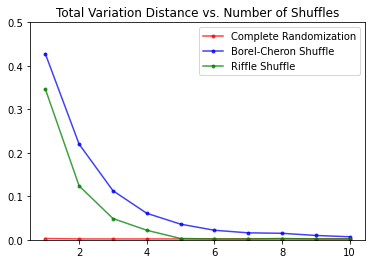

In [22]:
plt.plot(range(1, tMax+1), tvds_random, "r.-", label="Complete Randomization", alpha=0.75)
plt.plot(range(1, tMax+1), tvds_BC, "b.-", label="Borel-Cheron Shuffle", alpha=0.75)
plt.plot(range(1, tMax+1), tvds_RS, "g.-", label="Riffle Shuffle", alpha=0.75)
plt.ylim([0, 0.5])
plt.title("Total Variation Distance vs. Number of Shuffles")
plt.legend()
plt.show()

In [275]:
def riffle_shuffle(L, n):
        """See Saloff-Coste p. 273-4. Shuffles a bitstring of length L according to this riffle-shuffle model, n times."""
        deck = ("1"*(L//2)) + ("0"*(L//2))
        for _ in range(n):
            cutoff = 0
            for k in range(L+1):  # pick where to cut the deck
                r = random.random()
                binom = comb(L, k)/(2**L)
                if r <= binom:
                    cutoff = k
                    break

            pile1 = deck[0:cutoff]
            pile2 = deck[cutoff:L]
            a = len(pile1)
            b = len(pile2)
            final_deck = ""

            while pile1 or pile2:
                # as long as one pile has cards in it, a/(a+b) won't let an empty pile get picked
                r = random.random()
                if r <= a/(a+b):
                    next_card = pile1[-1]  # grab the last card
                    pile1 = pile1[:-1]
                else:
                    next_card = pile2[-1]
                    pile2 = pile2[:-1]

                final_deck = next_card + final_deck
                a = len(pile1)
                b = len(pile2)

                deck = final_deck

        return deck

In [259]:
def bitstring_to_id(b):
    L = len(b)
    minval = int("1"*(L//2), 2)
    return int(b, 2) - minval

In [260]:
b = riffle_shuffle(52)

TypeError: riffle_shuffle() missing 1 required positional argument: 'n'

In [261]:
int(b, 2)

4500604289429504

In [262]:
bitstring_to_id(b)

4500604222320641

In [263]:
b

'1111111111010100011010010111111100100011000000000000'

In [264]:
b.count("1")

26

In [265]:
bin(int(b, 2))

'0b1111111111010100011010010111111100100011000000000000'

In [305]:
tvds = []
L = 20
maxval = int(("1"*(L//2) + "0"*(L//2)), 2) + 1  # largest valid bitstring of length L with half 1s, half 0s
uniform = np.ones(maxval)/maxval
nIter = 10000
tMax = 10
for t in range(1, tMax+1):
    ps = np.zeros(maxval)
    for it in range(nIter):
        r = riffle_shuffle(L, t)
        identifier = int(r, 2)
        ps[identifier] += 1
    ps /= nIter
    tvds.append(tvd(ps[ps>0], uniform[ps>0]))

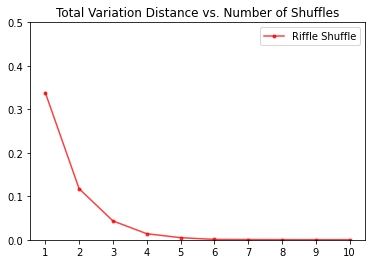

In [306]:
%matplotlib inline
plt.plot(range(1, tMax+1), tvds, "r.-", label="Riffle Shuffle", alpha=0.75)
plt.ylim([0, 0.5])
plt.xticks([x for x in range(1, tMax+1)])
plt.title("Total Variation Distance vs. Number of Shuffles")
plt.legend()
plt.savefig("TVDRiffleShuffle.png")

In [268]:
def flip_bits(b, L):
    """Given a binary number b, return b with all bits flipped. Will be considered of length L, so leading 0s
    added as needed."""
    x = bin(b)[2:]  # cut off the "0b" prefix
    x = ("0"*(L-len(x))) + x
    # I think we should just subtract b from the next highest power of 2
    # x = 2**(len(bin(b)) - 2) - b - 1
    y = int("0b" + x.replace("0", "p").replace("1", "0").replace("p", "1"), 2)
    # print(x == y)
    return y

In [269]:
def count_clumps(b):
    """Given a binary number b, return the longest clump of 1s in b's binary representation.
    See https://www.geeksforgeeks.org/length-longest-consecutive-1s-binary-representation/"""
    x = b
    count = 0
    while x:
        x = x & (x << 1)
        count += 1
    return count

In [276]:
tvds = []
clumps = []
L = 20
maxval = int(("1"*(L//2) + "0"*(L//2)), 2) + 1  # largest valid bitstring of length L with half 1s, half 0s
uniform = np.ones(maxval)/maxval
nIter = 10000
tMax = 10
for t in range(1, tMax+1):
    ps = np.zeros(maxval)
    c = []
    for it in range(nIter):
        r = riffle_shuffle(L, t)
        # a shuffle is a bit string with 1s being objects of a color and 0s being the other color
        # we identify each shuffle, i.e. arrangement, with the number its bit string represents in binary
        identifier = int(r, 2)
        ps[identifier] += 1
        c.append(max([count_clumps(identifier), count_clumps(flip_bits(identifier, L))]))
    ps /= nIter
    clumps.append((sum(c)/len(c))/L)
    tvds.append(tvd(ps[ps>0], uniform[ps>0]))

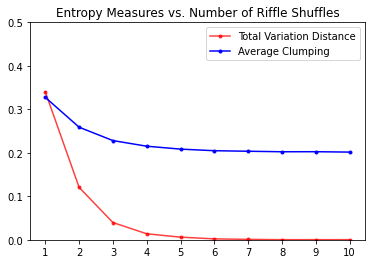

In [278]:
plt.plot(range(1, tMax+1), tvds, "r.-", label="Total Variation Distance", alpha=0.75)
plt.plot(range(1, tMax+1), clumps, "b.-", label="Average Clumping")
plt.ylim([0, 0.5])
plt.xticks([x for x in range(1, tMax+1)])
plt.title("Entropy Measures vs. Number of Riffle Shuffles")
plt.legend()
plt.savefig("TVD_Clumping_Graph.png")

In [284]:
from matplotlib.animation import FFMpegWriter

In [301]:
%matplotlib qt
LMax = 26
metadata = dict(title='TVD and Clumping vs. Time vs. Number of Cards', artist='Aaron Agulnick')
writer = FFMpegWriter(fps=5, metadata=metadata,bitrate=200000)
fig = plt.figure()
firsts = []

with writer.saving(fig, "TVDTest.mp4", dpi=200):
    for numCards in range(2, LMax+1):
        fig.clear()
        tvds = []
        clumps = []
        L = numCards
        epsilon = 0.15
        maxval = int(("1"*(L//2) + "0"*(L//2)), 2) + 1  # largest valid bitstring of length L with half 1s, half 0s
        uniform = np.ones(maxval)/maxval
        nIter = 10000
        tMax = 10
        first_sub_eps_found = False
        
        for t in range(1, tMax+1):
            ps = np.zeros(maxval)
            c = []
            for it in range(nIter):
                r = riffle_shuffle(L, t)
                # a shuffle is a bit string with 1s being objects of a color and 0s being the other color
                # we identify each shuffle, i.e. arrangement, with the number its bit string represents in binary
                identifier = int(r, 2)
                ps[identifier] += 1
                c.append(max([count_clumps(identifier), count_clumps(flip_bits(identifier, L))]))
            ps /= nIter
            clumps.append((sum(c)/len(c))/L)
            ttvd = tvd(ps[ps>0], uniform[ps>0])
            tvds.append(ttvd)
            if (not first_sub_eps_found) and ttvd < epsilon:
                first_sub_eps_found = True
                firsts.append(t)
        
        if not first_sub_eps_found:
            firsts.append(100)  # extreme value

        plt.plot(range(1, tMax+1), tvds, "r.-", label="Total Variation Distance", alpha=0.75)
        plt.plot(range(1, tMax+1), clumps, "b.-", label="Average Clumping")
        plt.ylim([0, 0.5])
        plt.xticks([x for x in range(1, tMax+1)])
        plt.title(f"Entropy Measures vs. Number of Riffle Shuffles: t = {numCards}")
        plt.legend()
        plt.draw()
        plt.pause(0.01)
        writer.grab_frame()

print("Finished!")

Finished!


In [302]:
firsts

[100,
 100,
 8,
 10,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]